# Feature Extraction
* A common method of EEG classification encountered during research of literary sources was feature extraction. 
* Using the data points of the signals is not a good way to classify.
* However, extracting statistical, and signal processing related features may help significantly improve our classification results.
* There are over a hundred features that can be extracted from EEG based on the sources read.
* This notebook will try to explore a few of in the following realms:
    1. Statisical 
        * mean, median, std, skewness, kurtosis, max and min
    2. Time Domain
        * hjorth paramter, 1st difference mean and maximum
    3. Frequency Domain
        * Converting time domain signals into frequency domain signals with Fourier transform.
        * Caluclating band power and max power with FT.
    4. Wavelet-based features
        * Discrete Wavelet Transform (High pass and Low Pass)
    5. Auto-regressive Coefficients
        * AR model of order 6 using Burg's Algorithm. Using the coefficients as features.
* All of the feature domains will be explained further throughout the notebook.

Source: [S. S. R, J. Rabha, K. Y. Nagarjuna, D. Samanta, P. Mitra and M. Sarma, "Motor Imagery EEG Signal Processing and Classification Using Machine Learning Approach," 2017 International Conference on New Trends in Computing Sciences (ICTCS), Amman, 2017, pp. 61-66.
doi: 10.1109/ICTCS.2017.15](https://ieeexplore-ieee-org.ccny-proxy1.libr.ccny.cuny.edu/document/8250265/citations)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time
import pickle
#need this to create pipeline for classification
from sklearn.pipeline import make_pipeline
#for scaling data into n_sample * n_feature array
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#classifer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                         cross_val_multiscore, LinearModel, get_coef, Vectorizer,CSP)
from mne.preprocessing import Xdawn
import os
import os.path as op
from os import listdir
from os.path import isfile, join
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'

#local path
path = 'C:\Users\Esimk\OneDrive\Desktop\eeg_data'

In [2]:
%run Functions.ipynb

In [ ]:
# subject_runs = get_subject_runs(path)
# filtered_epoch_files = get_filtered_epoch_files(subject_runs)


In [ ]:
with open('filtered_epoch_files.pkl', 'w') as f:
    pickle.dump(filtered_epoch_files, f)

In [3]:
with open('filtered_epoch_files.pkl', 'r') as f:
    files = np.array(pickle.load(f))

In [4]:
filtered_epoch_files = []
for f in files:
    filtered_epoch_files.append(f)

In [5]:
#get a random epoch file greater than 200 epochs
np.random.seed(42)
epoch_f = filtered_epoch_files[np.random.choice(len(filtered_epoch_files))]
print("epoch file name", epoch_f)
epochs = mne.read_epochs(epoch_f, preload=True)

('epoch file name', 'C:\\Users\\Esimk\\OneDrive\\Desktop\\eeg_data\\Ex10_Suj24_Run4-epo.fif')
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj24_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
263 matching events found
Created an SSP operator (subspace dimension = 1)
263 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


## Statistical Domain

### Mean

In [ ]:
def mean_of_epoch(epochs):
    epoch_means = []
    for i in range(1):
        print("i",i)
        means = []
        for j in range(20):
            print("j",j)
            mean = np.mean(epochs.get_data()[i,j,:])
            print(mean)
            means.append(means)
#         print("means", means)
        epoch_means.append(np.mean(means))
    return epoch_means

In [ ]:
epoch_means = mean_of_epoch(epochs)

In [ ]:
for mean in epoch_means:
    print(mean)

In [ ]:
np.mean(epochs.get_data()[0,3,:])

In [15]:
averages = []
for i in range(len(epochs['new'])):
    averages.append(epochs['new'][0].average())

In [19]:
event = averages[0]

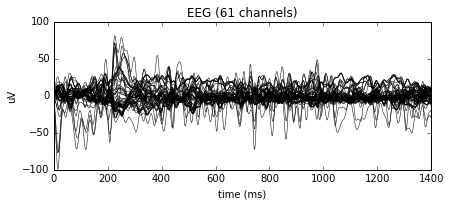

In [23]:
event.plot();